In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix

2025-11-09 13:08:53.980836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762693734.218169      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762693734.283966      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
data = pd.read_csv("/kaggle/input/mobile-reviews-sentiment-and-specification/Mobile Reviews Sentiment.csv")


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   review_id             50000 non-null  int64  
 1   customer_name         50000 non-null  object 
 2   age                   50000 non-null  int64  
 3   brand                 50000 non-null  object 
 4   model                 50000 non-null  object 
 5   price_usd             50000 non-null  float64
 6   price_local           50000 non-null  object 
 7   currency              50000 non-null  object 
 8   exchange_rate_to_usd  50000 non-null  float64
 9   rating                50000 non-null  int64  
 10  review_text           50000 non-null  object 
 11  sentiment             50000 non-null  object 
 12  country               50000 non-null  object 
 13  language              50000 non-null  object 
 14  review_date           50000 non-null  object 
 15  verified_purchase  

In [5]:
data.head()

,review_id,customer_name,age,brand,model,price_usd,price_local,currency,exchange_rate_to_usd,rating,...,verified_purchase,battery_life_rating,camera_rating,performance_rating,design_rating,display_rating,review_length,word_count,helpful_votes,source
0,1,Aryan Maharaj,45,Realme,Realme 12 Pro,337.31,₹27996.73,INR,83.00,2,...,True,1,1,3,2,1,46,7,1,Amazon
1,2,Davi Miguel Sousa,18,Realme,Realme 12 Pro,307.78,R$1754.35,BRL,5.70,4,...,True,3,2,4,3,2,74,12,5,Flipkart
2,3,Pahal Balay,27,Google,Pixel 6,864.53,₹71755.99,INR,83.00,4,...,True,3,5,3,2,4,55,11,8,AliExpress
3,4,David Guzman,19,Xiaomi,Redmi Note 13,660.94,د.إ2425.65,AED,3.67,3,...,False,1,3,2,1,2,66,11,3,Amazon
4,5,Yago Leão,38,Motorola,Edge 50,792.13,R$4515.14,BRL,5.70,3,...,True,3,3,2,2,1,73,12,0,BestBuy


In [6]:
data = data[["review_text","sentiment","battery_life_rating","camera_rating", "performance_rating", "design_rating", "display_rating"]].copy()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   review_text          50000 non-null  object
 1   sentiment            50000 non-null  object
 2   battery_life_rating  50000 non-null  int64 
 3   camera_rating        50000 non-null  int64 
 4   performance_rating   50000 non-null  int64 
 5   design_rating        50000 non-null  int64 
 6   display_rating       50000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 2.7+ MB


In [8]:
data.duplicated().sum()

18353

In [9]:
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   index                31647 non-null  int64 
 1   review_text          31647 non-null  object
 2   sentiment            31647 non-null  object
 3   battery_life_rating  31647 non-null  int64 
 4   camera_rating        31647 non-null  int64 
 5   performance_rating   31647 non-null  int64 
 6   design_rating        31647 non-null  int64 
 7   display_rating       31647 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.9+ MB


In [11]:
columns = ["sentiment", "battery_life_rating", "camera_rating", "performance_rating", "design_rating", "display_rating"]
for col in columns:
    values = data[col].value_counts().sort_index()
    print(f"\nColumn: {col}")
    print(values)


Column: sentiment
sentiment
Negative     4108
Neutral      8232
Positive    19307
Name: count, dtype: int64

Column: battery_life_rating
battery_life_rating
1    5280
2    7450
3    8788
4    6339
5    3790
Name: count, dtype: int64

Column: camera_rating
camera_rating
1    5312
2    7493
3    8664
4    6434
5    3744
Name: count, dtype: int64

Column: performance_rating
performance_rating
1    5341
2    7339
3    8722
4    6401
5    3844
Name: count, dtype: int64

Column: design_rating
design_rating
1    5209
2    7629
3    8725
4    6305
5    3779
Name: count, dtype: int64

Column: display_rating
display_rating
1    5257
2    7502
3    8564
4    6469
5    3855
Name: count, dtype: int64


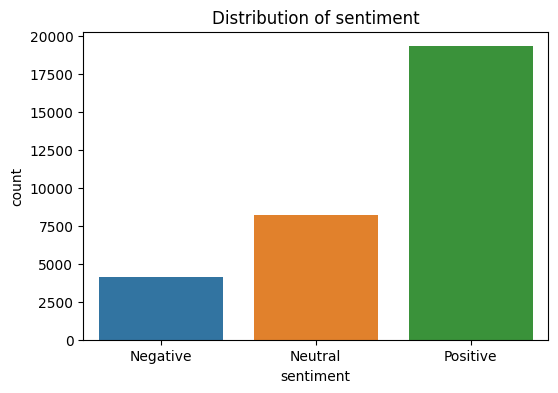

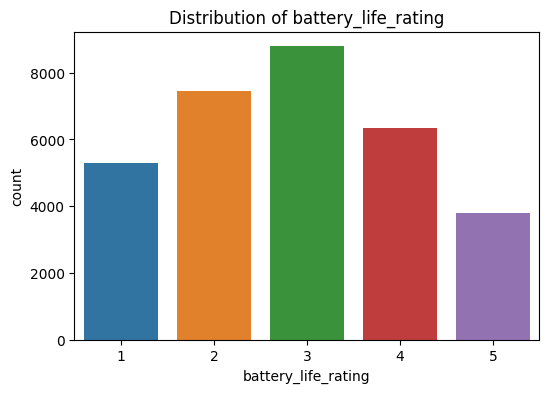

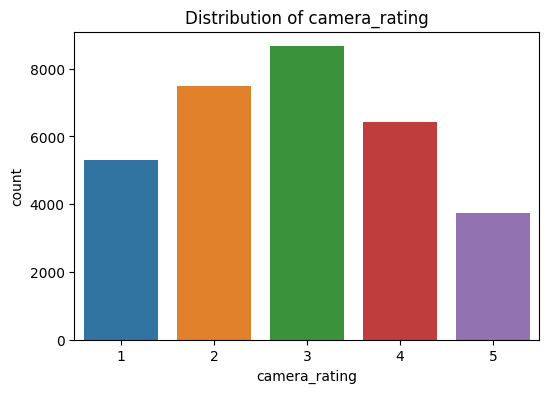

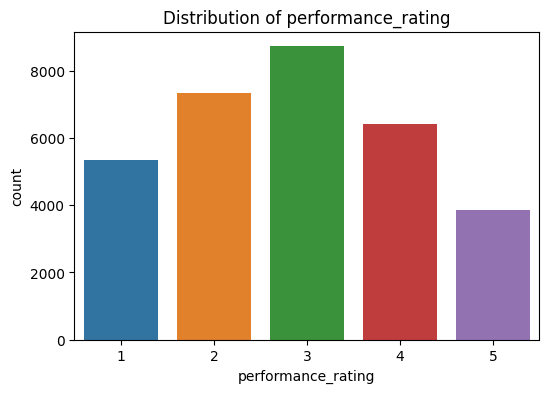

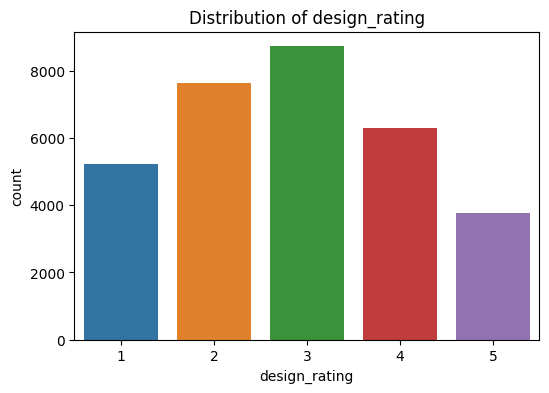

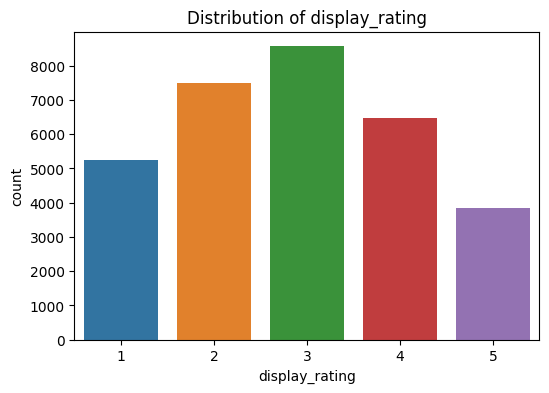

In [12]:
for col in columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=data, order=sorted(data[col].unique()))
    plt.title(f"Distribution of {col}")
    plt.show()


In [13]:
data["review_text"][4]

'Not bad for daily use but could be optimized. Average experience overall.'

In [14]:
def clean_review(text):
    if not isinstance(text,str):
        return ""
    text = text.lower()
    text = re.sub(f'\s+',' ', text).strip()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\d+', '', text)

    return text

In [15]:
data["clean_review"] = data["review_text"].apply(clean_review)

In [16]:
le = LabelEncoder()
data['sentiment_label'] = le.fit_transform(data['sentiment'])

X = data['clean_review'].values

y_ratings = data[["battery_life_rating","camera_rating","performance_rating","design_rating","display_rating"]].values
y_sentiment = data['sentiment_label'].values

X_train, X_val, y_ratings_train, y_ratings_val, y_sentiment_train, y_sentiment_val = train_test_split(
    X, y_ratings, y_sentiment, test_size=0.25, random_state=42
)

In [17]:
classes = np.array([0,1,2])
y_sentiment = data['sentiment_label'].values
class_weights = compute_class_weight('balanced', classes=classes, y=y_sentiment)
class_weight_dict = dict(zip(classes, class_weights))

print("\nClass Weights:")
print(class_weight_dict)

print("\nLabel Encoding:")
for i, class_label in enumerate(le.classes_):
    print(f"{class_label}: {i}")


Class Weights:
{0: 2.5679162609542354, 1: 1.2814625850340136, 2: 0.5463821411923137}

Label Encoding:
Negative: 0
Neutral: 1
Positive: 2


In [18]:
# Tokenize Text

MODEL_NAME = "bert-base-uncased"
MAX_LEN = 128

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def tokenize_texts(texts, max_len=MAX_LEN):
    return tokenizer(
        list(texts),
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="tf"
    )

train_encodings = tokenize_texts(X_train)
val_encodings = tokenize_texts(X_val)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
I0000 00:00:1762693767.521817      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762693767.522635      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [19]:
# Convert to plain dict for tf.data
train_encodings_tf = {
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask']
}
val_encodings_tf = {
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask']
}


In [20]:
# Create TensorFlow Datasets

val_fraction = 0.1
train_size = int((1 - val_fraction) * len(X_train))
val_size = len(X_train) - train_size

train_dataset = tf.data.Dataset.from_tensor_slices((
    train_encodings_tf,
    {
        "battery": y_ratings_train[:, 0],
        "camera": y_ratings_train[:, 1],
        "performance": y_ratings_train[:, 2],
        "design": y_ratings_train[:, 3],
        "display": y_ratings_train[:, 4],
        "sentiment": y_sentiment_train
    }
)).shuffle(1000)

# Split datasets
train_dataset_final = train_dataset.take(train_size).batch(16).prefetch(tf.data.AUTOTUNE)
val_dataset_small = train_dataset.skip(train_size).batch(16).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    val_encodings_tf,
    {
        "battery": y_ratings_val[:, 0],
        "camera": y_ratings_val[:, 1],
        "performance": y_ratings_val[:, 2],
        "design": y_ratings_val[:, 3],
        "display": y_ratings_val[:, 4],
        "sentiment": y_sentiment_val
    }
)).batch(16).prefetch(tf.data.AUTOTUNE)

In [21]:
# # Build Multi-Task BERT Model

# bert_model = TFBertModel.from_pretrained(MODEL_NAME)

# # Input layers
# input_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
# attention_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

# # Wrap BERT in Lambda to accept KerasTensors
# pooled_output = tf.keras.layers.Lambda(
#     lambda x: bert_model(input_ids=x[0], attention_mask=x[1])[1],
#     output_shape=(768,)
# )([input_ids, attention_mask])

# # Aspect rating heads (regression)
# battery = tf.keras.layers.Dense(1, name="battery")(pooled_output)
# camera = tf.keras.layers.Dense(1, name="camera")(pooled_output)
# performance = tf.keras.layers.Dense(1, name="performance")(pooled_output)
# design = tf.keras.layers.Dense(1, name="design")(pooled_output)
# display = tf.keras.layers.Dense(1, name="display")(pooled_output)

# # Sentiment head (classification)
# sentiment = tf.keras.layers.Dense(3, activation='softmax', name="sentiment")(pooled_output)

# # Create model
# model = tf.keras.Model(
#     inputs=[input_ids, attention_mask],
#     outputs=[battery, camera, performance, design, display, sentiment]
# )


# # Convert to tensor
# class_weight_tensor = tf.constant([class_weight_dict[0],
#                                    class_weight_dict[1],
#                                    class_weight_dict[2]], dtype=tf.float32)


In [22]:
@tf.keras.utils.register_keras_serializable()
class BertPoolingLayer(tf.keras.layers.Layer):
    def __init__(self, model_name="bert-base-uncased", trainable=True, **kwargs):
        super(BertPoolingLayer, self).__init__(**kwargs)
        self.bert_model = TFBertModel.from_pretrained(model_name)
        self.bert_model.trainable = trainable

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.pooler_output  # pooled_output

    def get_config(self):
        config = super(BertPoolingLayer, self).get_config()
        config.update({
            "model_name": self.bert_model.name,
            "trainable": self.bert_model.trainable
        })
        return config

In [23]:
# Inputs
input_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

# Use custom layer
pooled_output = BertPoolingLayer(MODEL_NAME)([input_ids, attention_mask])

# Regression heads
battery = tf.keras.layers.Dense(1, name="battery")(pooled_output)
camera = tf.keras.layers.Dense(1, name="camera")(pooled_output)
performance = tf.keras.layers.Dense(1, name="performance")(pooled_output)
design = tf.keras.layers.Dense(1, name="design")(pooled_output)
display = tf.keras.layers.Dense(1, name="display")(pooled_output)

# Sentiment classification
sentiment = tf.keras.layers.Dense(3, activation='softmax', name="sentiment")(pooled_output)

# Build model
model = tf.keras.Model(
    inputs=[input_ids, attention_mask],
    outputs=[battery, camera, performance, design, display, sentiment]
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were 

In [24]:
# @tf.keras.utils.register_keras_serializable()
# def weighted_sentiment_loss(y_true, y_pred):
#     y_true_int = tf.cast(y_true, tf.int32)
#     weights = tf.gather(class_weight_tensor, y_true_int)
#     unweighted_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
#     weighted_loss = unweighted_loss * weights
#     return tf.reduce_mean(weighted_loss)

In [25]:
CLASS_WEIGHTS = tf.constant([2.5679162609542354, 1.2814625850340136, 0.5463821411923137], dtype=tf.float32)

@tf.keras.utils.register_keras_serializable()
def weighted_sentiment_loss(y_true, y_pred):
    y_true_int = tf.cast(y_true, tf.int32)
    weights = tf.gather(CLASS_WEIGHTS, y_true_int)
    unweighted_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    weighted_loss = unweighted_loss * weights
    return tf.reduce_mean(weighted_loss)


In [26]:
# Compile model with loss_weights to prioritize sentiment
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss={
        "battery": "mse",
        "camera": "mse",
        "performance": "mse",
        "design": "mse",
        "display": "mse",
        "sentiment": weighted_sentiment_loss
    },
    loss_weights={
        "battery": 0.15,
        "camera": 0.15,
        "performance": 0.15,
        "design": 0.15,
        "display": 0.15,
        "sentiment": 1.5
    },
    metrics={
        "battery": "mae",
        "camera": "mae",
        "performance": "mae",
        "design": "mae",
        "display": "mae",
        "sentiment": "accuracy"
    }
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_pooling_layer  │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (BertPoolingLayer)  │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ battery (Dense)     │ (None, 1)         │        769 │ bert_pooling_lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ camera (Dense)      │ (None, 1)         │        769 │ bert_pooling_lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ performance (Dense) │ (None, 1)         │        769 │ bert_pooling_lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ design (Dense)      │ (None, 1)         │        769 │ bert_pooling_lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ display (Dense)     │ (None, 1)         │        769 │ bert_pooling_lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment (Dense)   │ (None, 3)         │      2,307 │ bert_pooling_lay… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,152 (24.03 KB)

 Trainable params: 6,152 (24.03 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Add early stopping and train for more epoch
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=2,
    restore_best_weights=True
)

# Training 
history = model.fit(
    train_dataset_final,
    validation_data=val_dataset_small,
    epochs=5,
    callbacks=[early_stopping],
    verbose=1
)

# Predict on validation dataset
preds = model.predict(val_dataset)

Epoch 1/5


I0000 00:00:1762693793.935267      61 service.cc:148] XLA service 0x78f7a0015a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762693793.936185      61 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762693793.936207      61 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1762693794.578222      61 assert_op.cc:38] Ignoring Assert operator functional_1/bert_pooling_layer_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
I0000 00:00:1762693796.538639      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1336 ━━━━━━━━━━━━━━━━━━━━ 7:09:21 19s/step - battery_loss: 18.5255 - battery_mae: 4.1636 - camera_loss: 19.3076 - camera_mae: 4.1866 - design_loss: 11.5815 - design_mae: 3.1977 - display_loss: 16.4947 - display_mae: 3.8002 - loss: 13.3219 - performance_loss: 11.2539 - performance_mae: 3.0868 - sentiment_accuracy: 0.0625 - sentiment_loss: 1.1650

I0000 00:00:1762693799.231942      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1335/1336 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - battery_loss: 7.6524 - battery_mae: 2.3026 - camera_loss: 6.5932 - camera_mae: 2.1189 - design_loss: 5.4799 - design_mae: 1.9169 - display_loss: 7.1946 - display_mae: 2.2248 - loss: 6.3695 - performance_loss: 4.3387 - performance_mae: 1.6900 - sentiment_accuracy: 0.2080 - sentiment_loss: 1.1205

W0000 00:00:1762693969.271003      62 assert_op.cc:38] Ignoring Assert operator functional_1/bert_pooling_layer_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert


1336/1336 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - battery_loss: 7.6496 - battery_mae: 2.3021 - camera_loss: 6.5908 - camera_mae: 2.1184 - design_loss: 5.4780 - design_mae: 1.9165 - display_loss: 7.1919 - display_mae: 2.2243 - loss: 6.3678 - performance_loss: 4.3373 - performance_mae: 1.6897 - sentiment_accuracy: 0.2081 - sentiment_loss: 1.1204

W0000 00:00:1762693976.080188      60 assert_op.cc:38] Ignoring Assert operator functional_1/bert_pooling_layer_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
W0000 00:00:1762693997.869285      62 assert_op.cc:38] Ignoring Assert operator functional_1/bert_pooling_layer_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert


1336/1336 ━━━━━━━━━━━━━━━━━━━━ 220s 150ms/step - battery_loss: 7.6468 - battery_mae: 2.3015 - camera_loss: 6.5884 - camera_mae: 2.1179 - design_loss: 5.4762 - design_mae: 1.9161 - display_loss: 7.1893 - display_mae: 2.2237 - loss: 6.3661 - performance_loss: 4.3359 - performance_mae: 1.6894 - sentiment_accuracy: 0.2082 - sentiment_loss: 1.1204 - val_battery_loss: 1.6961 - val_battery_mae: 1.0803 - val_camera_loss: 1.5876 - val_camera_mae: 1.0560 - val_design_loss: 1.6783 - val_design_mae: 1.0792 - val_display_loss: 1.5833 - val_display_mae: 1.0508 - val_loss: 2.7351 - val_performance_loss: 1.6252 - val_performance_mae: 1.0625 - val_sentiment_accuracy: 0.7607 - val_sentiment_loss: 1.0056
Epoch 2/5
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 206s 154ms/step - battery_loss: 1.6530 - battery_mae: 1.0662 - camera_loss: 1.5451 - camera_mae: 1.0361 - design_loss: 1.6004 - design_mae: 1.0503 - display_loss: 1.5979 - display_mae: 1.0558 - loss: 2.6993 - performance_loss: 1.5759 - performance_mae: 1.0406 - se

W0000 00:00:1762694825.755358      60 assert_op.cc:38] Ignoring Assert operator functional_1/bert_pooling_layer_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert


494/495 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step

W0000 00:00:1762694896.363256      63 assert_op.cc:38] Ignoring Assert operator functional_1/bert_pooling_layer_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert


495/495 ━━━━━━━━━━━━━━━━━━━━ 75s 145ms/step


In [28]:
# preds is a list of 6 elements: [battery, camera, performance, design, display, sentiment_probs]
battery_pred = preds[0].flatten()
camera_pred = preds[1].flatten()
performance_pred = preds[2].flatten()
design_pred = preds[3].flatten()
display_pred = preds[4].flatten()
sentiment_probs = preds[5]

# Convert sentiment probabilities to class labels
sentiment_pred = np.argmax(sentiment_probs, axis=1)


# Collect true labels from val_dataset
y_true_battery = []
y_true_camera = []
y_true_performance = []
y_true_design = []
y_true_display = []
y_true_sentiment = []

for batch in val_dataset:
    y_batch = batch[1]
    y_true_battery.extend(y_batch['battery'].numpy())
    y_true_camera.extend(y_batch['camera'].numpy())
    y_true_performance.extend(y_batch['performance'].numpy())
    y_true_design.extend(y_batch['design'].numpy())
    y_true_display.extend(y_batch['display'].numpy())
    y_true_sentiment.extend(y_batch['sentiment'].numpy())

y_true_battery = np.array(y_true_battery)
y_true_camera = np.array(y_true_camera)
y_true_performance = np.array(y_true_performance)
y_true_design = np.array(y_true_design)
y_true_display = np.array(y_true_display)
y_true_sentiment = np.array(y_true_sentiment)


In [29]:
# Evaluation
def evaluate_regression(y_true, y_pred, name=""):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} - MAE: {mae:.3f}, MSE: {mse:.3f}")


print("REGRESSION RESULTS (Aspect Ratings)")
evaluate_regression(y_true_battery, battery_pred, "Battery")
evaluate_regression(y_true_camera, camera_pred, "Camera")
evaluate_regression(y_true_performance, performance_pred, "Performance")
evaluate_regression(y_true_design, design_pred, "Design")
evaluate_regression(y_true_display, display_pred, "Display")


# Classification report
print("CLASSIFICATION RESULTS (Sentiment)")
print("\nSentiment Classification Report:")
print(classification_report(y_true_sentiment, sentiment_pred, target_names=["Negative","Neutral","Positive"], zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true_sentiment, sentiment_pred)
print("\nConfusion Matrix:")
print(cm)

REGRESSION RESULTS (Aspect Ratings)
Battery - MAE: 1.003, MSE: 1.470
Camera - MAE: 0.993, MSE: 1.414
Performance - MAE: 0.999, MSE: 1.441
Design - MAE: 0.988, MSE: 1.421
Display - MAE: 1.003, MSE: 1.437
CLASSIFICATION RESULTS (Sentiment)

Sentiment Classification Report:
              precision    recall  f1-score   support

    Negative       0.72      0.87      0.79      1028
     Neutral       0.88      0.89      0.89      2074
    Positive       1.00      0.95      0.97      4810

    accuracy                           0.92      7912
   macro avg       0.87      0.90      0.88      7912
weighted avg       0.93      0.92      0.93      7912


Confusion Matrix:
[[ 892  136    0]
 [ 221 1853    0]
 [ 118  121 4571]]


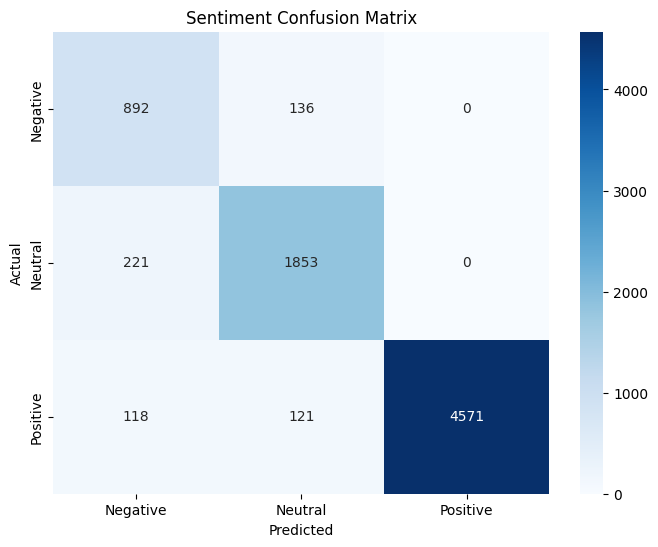

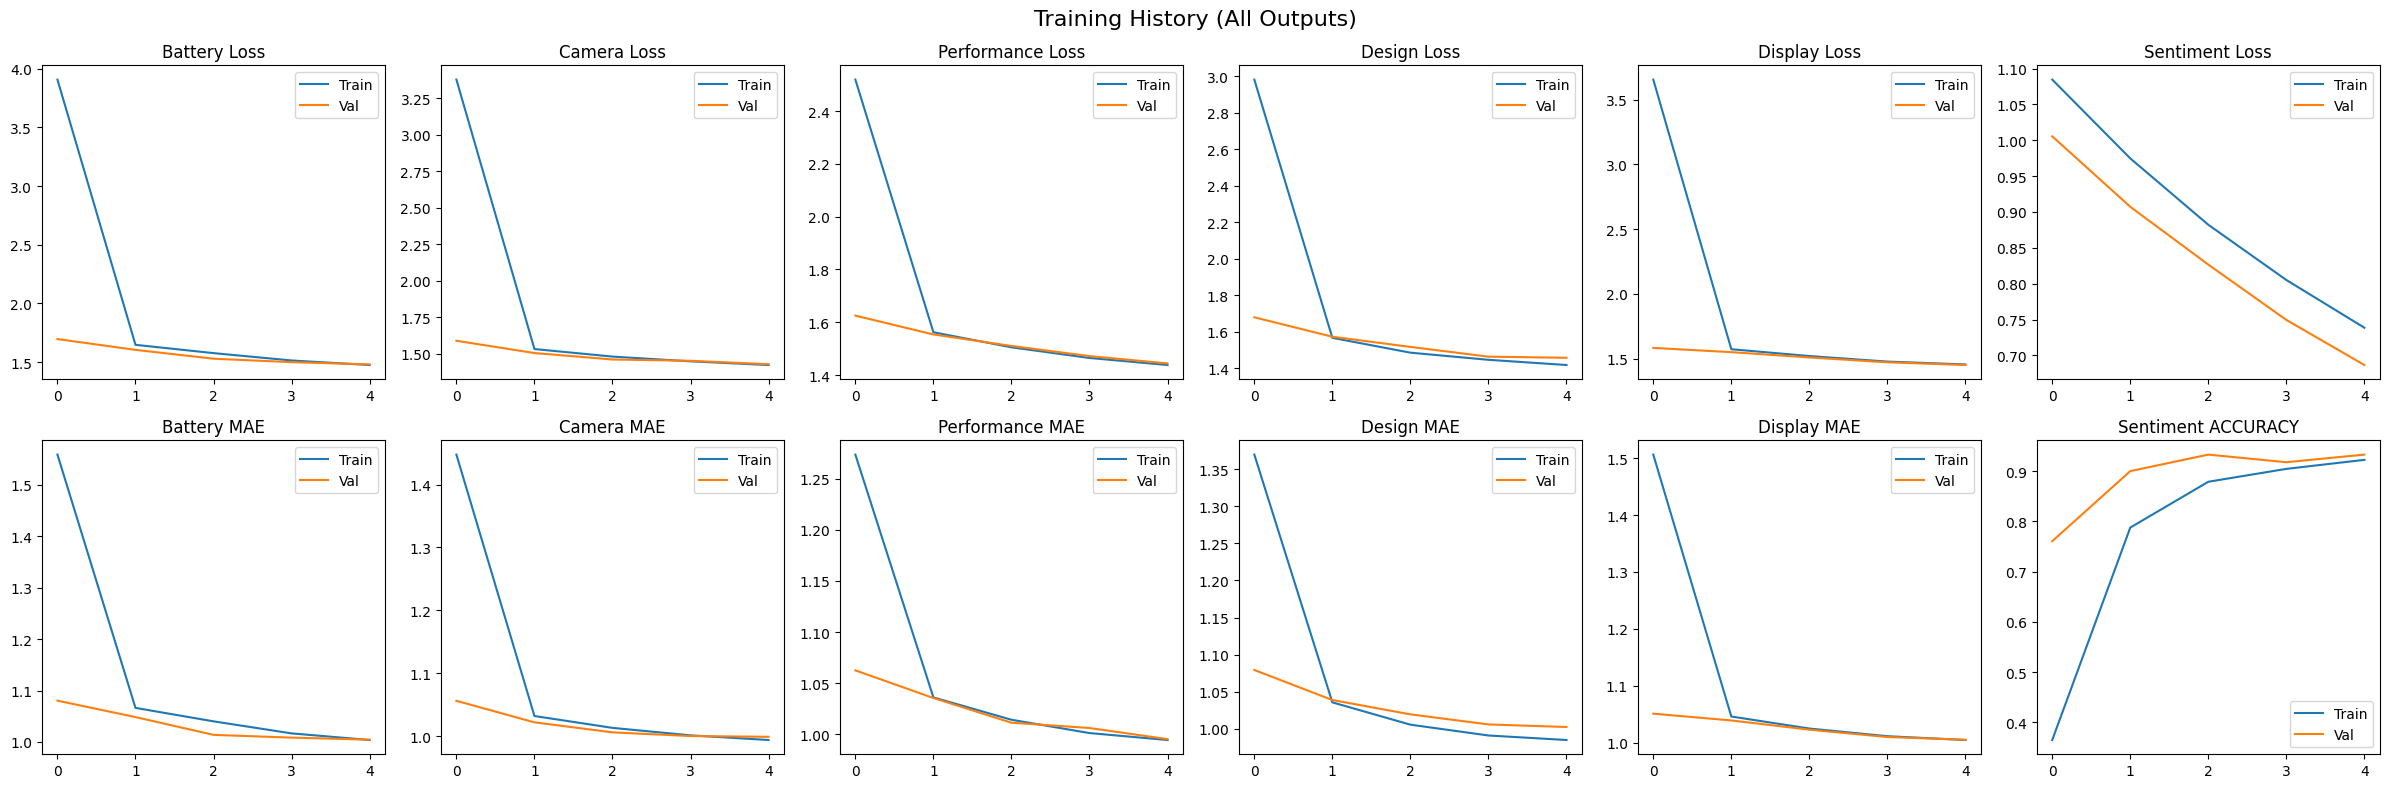

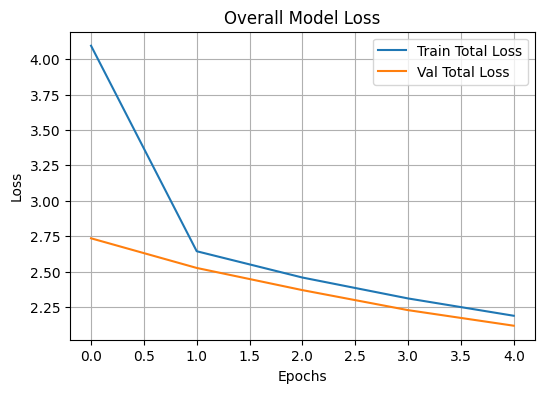

In [30]:
plt.figure(figsize=(8,6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Negative","Neutral","Positive"],
    yticklabels=["Negative","Neutral","Positive"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Sentiment Confusion Matrix")
plt.show()


# TRAINING HISTORY (All Outputs)

output_heads = ["battery", "camera", "performance", "design", "display", "sentiment"]

fig, axes = plt.subplots(2, len(output_heads), figsize=(4*len(output_heads), 8))
fig.suptitle("Training History (All Outputs)", fontsize=16)

# Plot individual losses
for i, head in enumerate(output_heads):
    ax = axes[0, i]
    train_loss_key = f"{head}_loss"
    val_loss_key = f"val_{head}_loss"
    if train_loss_key in history.history:
        ax.plot(history.history[train_loss_key], label="Train")
        ax.plot(history.history[val_loss_key], label="Val")
        ax.set_title(f"{head.capitalize()} Loss")
        ax.legend()
    else:
        ax.axis("off")

# Plot metrics
for i, head in enumerate(output_heads):
    ax = axes[1, i]
    # For regression heads → MAE, for sentiment → accuracy
    metric_name = "mae" if head != "sentiment" else "accuracy"
    train_metric_key = f"{head}_{metric_name}"
    val_metric_key = f"val_{head}_{metric_name}"
    if train_metric_key in history.history:
        ax.plot(history.history[train_metric_key], label="Train")
        ax.plot(history.history[val_metric_key], label="Val")
        ax.set_title(f"{head.capitalize()} {metric_name.upper()}")
        ax.legend()
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()


# TOTAL LOSS PLOT

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Total Loss')
plt.plot(history.history['val_loss'], label='Val Total Loss')
plt.title("Overall Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [31]:
# Save the model and tokenizer
model.save("/kaggle/working/multitask_bert_model.keras") 
tokenizer.save_pretrained("/kaggle/working/multitask_bert_model")

('/kaggle/working/multitask_bert_model/tokenizer_config.json',
 '/kaggle/working/multitask_bert_model/special_tokens_map.json',
 '/kaggle/working/multitask_bert_model/vocab.txt',
 '/kaggle/working/multitask_bert_model/added_tokens.json')